# Assignment 2 - 2.2: Neural Network

### Overview

In this question, you will implement a CNN model and train it on Fasion-MNIST, which is focusing on image classification. The model structure is similar with that in Written Problem 1.2.

### Dataset Introduction

First it's important to have an overall knowledge of this dataset. The dataset is called **Fashion-MNIST**, a member of the MNIST family. This dataset is an image classification task with ten categories, all of which are items from our daily lives. It consists of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image. It means that we can use 784 numbers (in the range of 0~255) to represent one image. More details can be found in https://github.com/zalandoresearch/fashion-mnist.

After downloading the data directory from BB, put this notebook file at the same position as "data". And this block of code will help to load the data, including basic preprocessing.

In [4]:
import numpy as np
import gzip
import random
import os
import matplotlib.pyplot as plt

def load_mnist(path, kind, subset=None):
    labels_path = os.path.join(path, '%s-labels-idx1-ubyte.gz'%kind)
    images_path = os.path.join(path, '%s-images-idx3-ubyte.gz'%kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8, offset=8)
    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8, offset=16).reshape(len(labels), 784)

    if subset is not None:
        selected_images, selected_labels = [], []
        for label in range(10):
            indices = np.where(labels == label)[0]
            selected_indices = np.random.choice(indices, subset, replace=False)
            selected_images.append(images[selected_indices])
            selected_labels.append(labels[selected_indices])
        images = np.concatenate(selected_images, axis=0)
        labels = np.concatenate(selected_labels, axis=0)

        paired = list(zip(images, labels))
        random.shuffle(paired)
        images, labels = zip(*paired)

    return np.array(images), np.array(labels)


X_train, y_train = load_mnist('./P2_data/', kind='train')
X_test, y_test = load_mnist('./P2_data/', kind='t10k')

X_train = X_train.reshape((X_train.shape[0], 28, 28, 1)).astype('float32') / 255
X_test = X_test.reshape((X_test.shape[0], 28, 28, 1)).astype('float32') / 255

This block will randomly select one sample from the dataset, displaying the label index, label name, and the corresponding image.

The label index of this image is: 8
The label name of this graph is: Bag


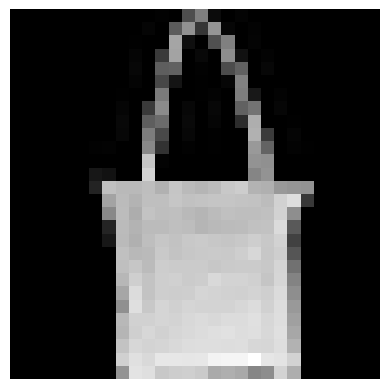

In [6]:
label_names = ["T-shirt/top","Trouser","Pullover","Dress","Coat","Sandal","Shirt","Sneaker","Bag","Ankle boot"]
idx = random.choice(range(0,len(X_test)))
print(f"The label index of this image is: {y_test[idx]}")
print(f"The label name of this graph is: {label_names[y_test[idx]]}")

plt.imshow(X_test[idx].reshape(28, 28), cmap='gray')
plt.axis('off')
plt.show()

Now we are supposed to build a simple CNN model to train on the data above and test it using the test set. Here we will use PyTorch for implementation. First we can get familiar with the torch by https://docs.pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html. We can install it by running `pip install torch` in the terminal.

In [7]:
import tqdm
import torch
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F

Recall that the CNN structure is defined as:

Conv3(16) + Maxpool2 + Conv5(24) + Maxpool2 + FC10

where

- Conv3(16): 16 filters with each size 3\*3\*D, where D is the depth of the activation volume at the previous layer, stride = 1, padding = 1;
- Conv5(24): 24 filters with each size 5\*5\*D, where D is the depth of the activation volume at the previous layer, stride = 1, padding = 2;
- Maxpool2: 2*2 filter, stride = 2, padding = 0;
- FC10: A fully-connected layer with 10 output neurons.

Here you need to first define each layer in the _\_\_init\_\__ function and then connect them in order in the _forward_ function. Remember to write the code between "Begin of your code" and "End of your code".

In [8]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        ###############################################################################
        # Begin of your code

        # Conv3(16): 16 filters, 3x3 kernel, stride=1, padding=1
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        # Maxpool2: 2x2 filter, stride=2, padding=0
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        # Conv5(24): 24 filters, 5x5 kernel, stride=1, padding=2
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=24, kernel_size=5, stride=1, padding=2)
        # Maxpool2: 2x2 filter, stride=2, padding=0
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        # FC10: Fully connected layer with 10 output neurons
        # After two maxpool layers: 28 -> 14 -> 7
        self.fc = nn.Linear(24 * 7 * 7, 10)

        # End of your code
        ###############################################################################
    

    def forward(self, x):

        ###############################################################################
        # Begin of your code

        # Conv3(16) + ReLU
        x = F.relu(self.conv1(x))
        # Maxpool2
        x = self.pool1(x)
        
        # Conv5(24) + ReLU
        x = F.relu(self.conv2(x))
        # Maxpool2
        x = self.pool2(x)
        
        # Flatten the tensor for fully connected layer
        x = x.view(x.size(0), -1)
        # FC10
        x = self.fc(x)

        # End of your code
        ###############################################################################
        
        return x

model = CNN()
print(model)

CNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 24, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=1176, out_features=10, bias=True)
)


Then we can train our model with batch_size=64, learning_rate=0.001, and total_epoch=10. Feel free to modify these hyperparameters if you think it will be better. If you use CPU, it will take several minute to complete the training process. Be patient.

In [9]:
# Convert numpy arrays to PyTorch tensors
X_train_tensor = torch.from_numpy(X_train).permute(0, 3, 1, 2)
y_train_tensor = torch.from_numpy(y_train).long()
X_test_tensor = torch.from_numpy(X_test).permute(0, 3, 1, 2)
y_test_tensor = torch.from_numpy(y_test).long()

# Create datasets and dataloaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training
num_epochs = 10
for epoch in tqdm.trange(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    train_accuracy = 100 * correct / total
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Train Accuracy: {train_accuracy:.2f}%')

 10%|█         | 1/10 [00:01<00:15,  1.75s/it]

Epoch [1/10], Loss: 0.5165, Train Accuracy: 81.68%


 20%|██        | 2/10 [00:03<00:12,  1.58s/it]

Epoch [2/10], Loss: 0.3401, Train Accuracy: 87.73%


 30%|███       | 3/10 [00:04<00:10,  1.54s/it]

Epoch [3/10], Loss: 0.2994, Train Accuracy: 89.22%


 40%|████      | 4/10 [00:06<00:09,  1.53s/it]

Epoch [4/10], Loss: 0.2745, Train Accuracy: 90.12%


 50%|█████     | 5/10 [00:07<00:07,  1.52s/it]

Epoch [5/10], Loss: 0.2542, Train Accuracy: 90.77%


 60%|██████    | 6/10 [00:09<00:06,  1.50s/it]

Epoch [6/10], Loss: 0.2410, Train Accuracy: 91.23%


 70%|███████   | 7/10 [00:10<00:04,  1.50s/it]

Epoch [7/10], Loss: 0.2282, Train Accuracy: 91.67%


 80%|████████  | 8/10 [00:12<00:03,  1.50s/it]

Epoch [8/10], Loss: 0.2169, Train Accuracy: 92.17%


 90%|█████████ | 9/10 [00:13<00:01,  1.50s/it]

Epoch [9/10], Loss: 0.2074, Train Accuracy: 92.47%


100%|██████████| 10/10 [00:15<00:00,  1.52s/it]

Epoch [10/10], Loss: 0.1995, Train Accuracy: 92.70%


After training, the final step is to verify if our model does well in this classification task.

In [10]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
print(f'\nTest Accuracy: {test_accuracy:.2f}%')


Test Accuracy: 90.77%


Note that if you obtain a good test score (larger than 80%), you will get full marks in this problem. The test score is usually around 90% for this CNN structure and training configuration.